# Simple SNN classification of NMNIST Event Based Data

### Required Libraries

In [1]:
!pip install tonic --quiet
!pip install snntorch --quiet
!pip install torch --quiet
!pip install torchvision --quiet
!pip install pandas --quiet
!pip install matplotlib --quiet
!conda install -c conda-forge ffmpeg -y --quiet
!pip install torchsummary --quiet

/opt/conda/lib/python3.12/site-packages/conda/base/context.py:202: FutureWarning: Adding 'defaults' to channel list implicitly is deprecated and will be removed in 25.3. 

To remove this warning, please choose a default channel explicitly with conda's regular configuration system, e.g. by adding 'defaults' to the list of channels:

  conda config --add channels defaults

For more information see https://docs.conda.io/projects/conda/en/stable/user-guide/configuration/use-condarc.html

  deprecated.topic(
Channels:
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: ...working... done

# All requested packages already installed.



In [2]:
import snntorch as snn                  # Main SNN library
from snntorch import surrogate          # Surrogate gradient functions
from snntorch import functional as SF   # Loss functions and utilities
from snntorch import spikeplot as splt  # Visualization tools
from snntorch import utils              # Utility functions
import torch.nn as nn                   # PyTorch neural network modules
import torch
import torchvision                      # Computer vision transforms
from torch.utils.data import DataLoader
import tonic                            # Neuromorphic datasets
import torch.nn.functional as F
import tonic.transforms as transforms
from tonic import DiskCachedDataset
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML
import torchsummary

/workspaces/MNMISTSnnTorch/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load and prep data

In [3]:
# dataloader arguments
batch_size = 128
data_path='/tmp/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
# Data
# Get sensor dimensions for NMNIST dataset
sensor_size = tonic.datasets.NMNIST.sensor_size

# Define transformations for event data
# - Denoise removes isolated events over 10000μs window
# - ToFrame converts events to frames with 1000μs time window
frame_transform = transforms.Compose([transforms.Denoise(filter_time=10000),
                                      transforms.ToFrame(sensor_size=sensor_size,
                                                         time_window=1000)
                                     ])

# Load NMNIST dataset with transformations
trainset = tonic.datasets.NMNIST(save_to='./tmp/data', transform=frame_transform, train=True)
testset = tonic.datasets.NMNIST(save_to='./tmp/data', transform=frame_transform, train=False)

# Define augmentation transforms for training data
# Converts numpy array to tensor and applies random rotation
transform = tonic.transforms.Compose([torch.from_numpy,
                                      torchvision.transforms.RandomRotation([-10,10])])

# Cache datasets to disk for faster loading
cached_trainset = DiskCachedDataset(trainset, transform=transform, cache_path='./cache/nmnist/train')
cached_testset = DiskCachedDataset(testset, cache_path='./cache/nmnist/test')

# Configure data loaders
# PadTensors ensures all samples in batch have same dimensions by padding shorter sequences
train_loader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)
test_loader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False))


The target label is: 2
Sample shape: torch.Size([311, 34, 34])


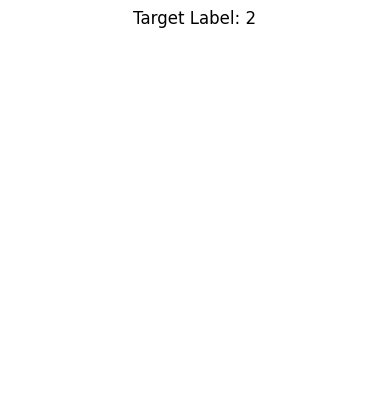

In [5]:
# Example datapoint

data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

idx = 1
print(f"The target label is: {targets[idx]}")
fig, ax = plt.subplots()
sample = data[:, idx, 0]
print(f"Sample shape: {sample.shape}")
ax.set_title(f"Target Label: {targets[idx]}")
anim = splt.animator(sample.detach().cpu(), fig, ax)

# anim.save(f"data-label-{targets[idx]}.mp4")
HTML(anim.to_html5_video())

### The Net
Thank you SNNtorch documentation

In [6]:
# Leaky neuron model, overriding the backward pass with a custom function
class LeakySigmoidSurrogate(nn.Module):
  def __init__(self, beta, threshold=1.0, k=25):

      # Leaky_Surrogate is defined in the previous tutorial and not used here
      super(Leaky_Surrogate, self).__init__()

      # initialize decay rate beta and threshold
      self.beta = beta
      self.threshold = threshold
      self.surrogate_func = self.FastSigmoid.apply

  # the forward function is called each time we call Leaky
  def forward(self, input_, mem):
    spk = self.surrogate_func((mem-self.threshold))  # call the Heaviside function
    reset = (spk - self.threshold).detach()
    mem = self.beta * mem + input_ - reset
    return spk, mem

  # Forward pass: Heaviside function
  # Backward pass: Override Dirac Delta with gradient of fast sigmoid
  @staticmethod
  class FastSigmoid(torch.autograd.Function):
    @staticmethod
    def forward(ctx, mem, k=25):
        ctx.save_for_backward(mem) # store the membrane potential for use in the backward pass
        ctx.k = k
        out = (mem > 0).float() # Heaviside on the forward pass: Eq(1)
        return out

    @staticmethod
    def backward(ctx, grad_output):
        (mem,) = ctx.saved_tensors  # retrieve membrane potential
        grad_input = grad_output.clone()
        grad = grad_input / (ctx.k * torch.abs(mem) + 1.0) ** 2  # gradient of fast sigmoid on backward pass: Eq(4)
        return grad, None

In [7]:
# neuron and simulation parameters
spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.5
num_steps = 50

In [8]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.conv1 = nn.Conv2d(2, 12, 5)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.conv2 = nn.Conv2d(12, 64, 5)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.fc1 = nn.Linear(64*5*5, 10)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad)

    def forward(self, x):

        # Initialize hidden states and outputs at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        cur1 = F.max_pool2d(self.conv1(x), 2)
        spk1, mem1 = self.lif1(cur1, mem1)

        cur2 = F.max_pool2d(self.conv2(spk1), 2)
        spk2, mem2 = self.lif2(cur2, mem2)
        # return spk2, mem2

        cur3 = self.fc1(spk2.view(spk2.shape[0], -1))
        spk3, mem3 = self.lif3(cur3, mem3)
        return spk3, mem3

#  Initialize Network
net = Net().to(device)

torchsummary.summary(net, (2, 34, 34))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 30, 30]             612
             Leaky-2  [[-1, 12, 15, 15], [-1, 12, 15, 15]]               0
            Conv2d-3           [-1, 64, 11, 11]          19,264
             Leaky-4  [[-1, 64, 5, 5], [-1, 64, 5, 5]]               0
            Linear-5                   [-1, 10]          16,010
             Leaky-6       [[-1, 10], [-1, 10]]               0
Total params: 35,886
Trainable params: 35,886
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 75.01
Params size (MB): 0.14
Estimated Total Size (MB): 75.15
----------------------------------------------------------------


### Training and such

In [9]:
def forward_pass(net, data):
    spk_rec = []
    utils.reset(net)  # Reset all neuron states

    for step in range(data.size(0)):  # Iterate through each timestep
        spk_out, mem_out = net(data[step])
        spk_rec.append(spk_out)

    return torch.stack(spk_rec)

In [ ]:
def batch_accuracy(train_loader, net, num_steps):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()

    train_loader = iter(train_loader)
    for data, targets in train_loader:
      data = data.to(device)
      targets = targets.to(device)
      spk_rec, _ = forward_pass(net, num_steps, data)

      acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
      total += spk_rec.size(1)

  return acc/total

: 

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)
num_epochs = 1
loss_hist = []
test_acc_hist = []
counter = 0

for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(train_loader)):
        # Move data to appropriate device
        data = data.to(device)
        targets = targets.to(device)

        # Training mode and forward pass
        net.train()
        spk_rec = forward_pass(net, data)
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation and weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Record loss
        loss_hist.append(loss_val.item())

        print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

        # Calculate and record accuracy
        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)
        print(f"Accuracy: {acc * 100:.2f}%\n")
